<a href="https://colab.research.google.com/github/eebeohar/stock_predict/blob/main/assign_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler as MMS
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from os import listdir
from os.path import isfile, join
import os
from datetime import datetime
import random
import seaborn as sns

In [ ]:
# File Path
file_list= (glob.glob("/content/drive/MyDrive/IIT assignment Indira securities/*.pkl"))

In [ ]:
with open(file_list[0], 'rb') as file:
      ohlc_data_dum = pickle.load(file)
      df_dum = pd.DataFrame(ohlc_data_dum)
      df_dum.reset_index(inplace=True)
      df_dum.head()
      df_dum['date'] = pd.to_datetime(df_dum['timestamp_epoch'],unit='us')

<ipython-input-3-cb0071031b5d>:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_dum['date'] = pd.to_datetime(df_dum['timestamp_epoch'],unit='us')


In [ ]:
df_dum.head()

,index,sno,timestamp_epoch,symbol_id,order_type,buy_sell,order_no,order_no2,price,vol,date
0,1,16012,1736221074571346,11971,T,,0,0,417.8,60.0,2025-01-07 03:37:54.571346
1,2,16013,1736221074571349,11971,T,,0,0,417.8,39.0,2025-01-07 03:37:54.571349
2,3,16014,1736221074571351,11971,T,,0,0,417.8,25.0,2025-01-07 03:37:54.571351
3,4,16015,1736221074571353,11971,T,,0,0,417.8,400.0,2025-01-07 03:37:54.571353
4,5,16016,1736221074571354,11971,T,,0,0,417.8,125.0,2025-01-07 03:37:54.571354


In [ ]:
# Filtering data within the required timeframe
df_dum=df_dum[(df_dum['date']>='2025-01-07 09:15:00')&(df_dum['date']<='2025-01-07 15:30:00')]

In [ ]:
df_dum['date'] = pd.to_datetime(df_dum['date'])

# Filtering trades data with valid order numbers
df_dum_T=df_dum[(df_dum['order_no2'].values !='0') & (df_dum['order_no2'].values !=u'') ]

#Creating a dummy df for evaluating volume per minute influx for this data
df_per_min =  pd.DataFrame({'date':df_dum_T['date'],'vol_per_min':df_dum_T['vol'].values})

<ipython-input-5-12af079c0cf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dum['date'] = pd.to_datetime(df_dum['date'])


In [ ]:
df_per_min=df_per_min.groupby(pd.Grouper(key='date', axis=0, freq='1min')).sum()
df_per_min.head()

,vol_per_min
date,
2025-01-07 09:15:00,14654.0
2025-01-07 09:16:00,21898.0
2025-01-07 09:17:00,4760.0
2025-01-07 09:18:00,7952.0
2025-01-07 09:19:00,8910.0


# Volume per minute flux for trades

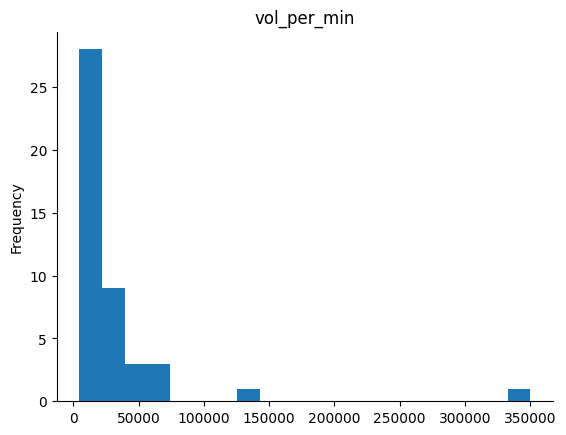

In [ ]:
df_per_min['vol_per_min'].plot(kind='hist', bins=20, title='vol_per_min')
plt.gca().spines[['top', 'right',]].set_visible(False)

Majority of the volume per minute traded was less than 50000.

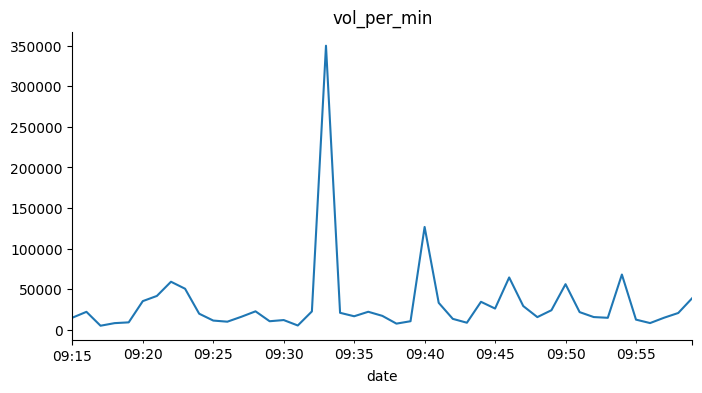

In [ ]:
df_per_min['vol_per_min'].plot(kind='line', figsize=(8, 4), title='vol_per_min')
plt.gca().spines[['top', 'right']].set_visible(False)

The peak trading time seems to be between from 9:30 to 9:35. The least trading activity is from 9:15 to around 9:17.

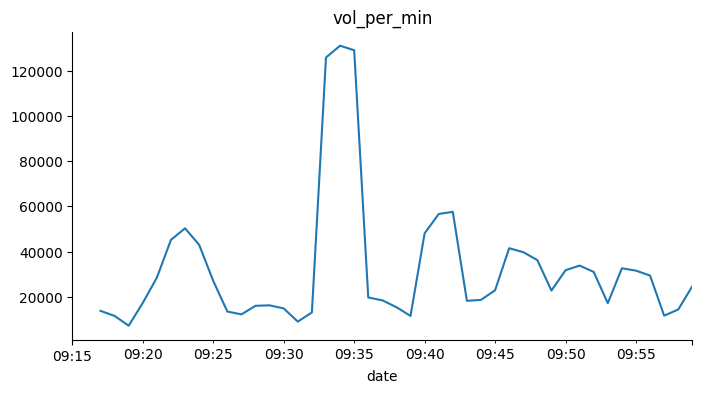

In [ ]:
df_per_min['MA_vol_per_min']=df_per_min.rolling(window=3)['vol_per_min'].mean()
df_per_min['MA_vol_per_min'].plot(kind='line', figsize=(8, 4), title='vol_per_min')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from scipy.signal import find_peaks
min_peaks = find_peaks(-1*df_per_min['MA_vol_per_min'])[0]
max_peaks = find_peaks(df_per_min['MA_vol_per_min'])[0]

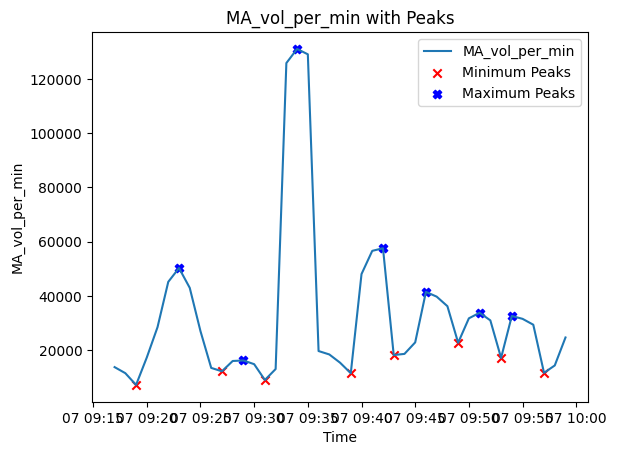

In [ ]:
# First, plot the 'MA_vol_per_min' series as a line
plt.plot(df_per_min.index, df_per_min['MA_vol_per_min'], label='MA_vol_per_min')

# Then, overlay the peaks as scatter points
plt.scatter(df_per_min.index[min_peaks], df_per_min['MA_vol_per_min'].values[min_peaks], color='red', marker='x', label='Minimum Peaks')
plt.scatter(df_per_min.index[max_peaks], df_per_min['MA_vol_per_min'].values[max_peaks], color='blue', marker='X', label='Maximum Peaks')

# Add labels, title, and legend (optional but recommended)
plt.xlabel('Time')
plt.ylabel('MA_vol_per_min')
plt.title('MA_vol_per_min with Peaks')
plt.legend()

# Show the plot
plt.show()


In [ ]:
print('max_trading time stamp', df_per_min.idxmax()['vol_per_min'])
print('max_trading time stamp', df_per_min.idxmin()['vol_per_min'])

max_trading time stamp 2025-01-07 09:33:00
max_trading time stamp 2025-01-07 09:17:00


# Unusual Trades vs. Normal Trades

In [ ]:
df_order_comp=df_dum[(df_dum['order_no2'].values=='0') | (df_dum['order_no'].values=='0')  | (df_dum['order_no2'].values==u'') & (df_dum['order_type'].values=='T')]
# df_order_comp
total_T_order=df_dum[(df_dum['order_type'].values=='T')]
# df_order_comp

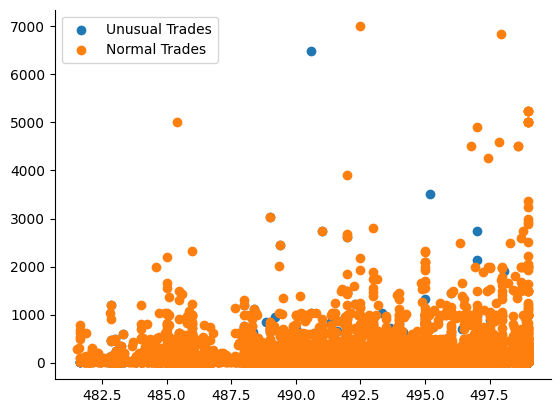

In [ ]:
# from matplotlib import pyplot as plt
# df_order_comp.plot(kind='scatter', x='price', y='vol', s=32, alpha=.8,color='red')
# df_dum_T.plot(kind='scatter', x='price', y='vol', s=32, alpha=.8,color='green')
plt.scatter(df_order_comp['price'].values,df_order_comp['vol'].values)
plt.scatter(df_dum_T['price'].values,df_dum_T['vol'].values)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.legend(['Unusual Trades','Normal Trades'])

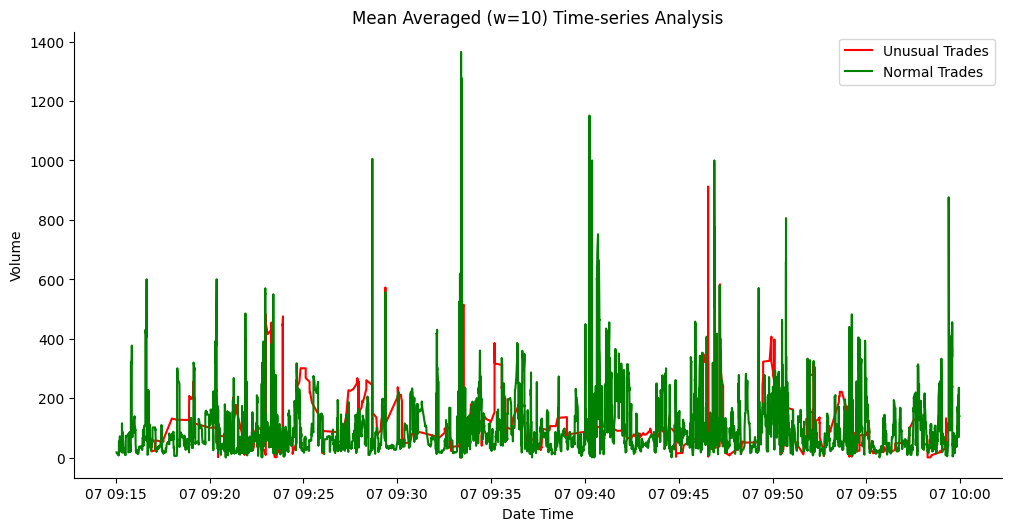

In [ ]:
def _plot_series_vol(series, series_name, series_index=0,color='blue',window=10):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series.rolling(window=window)['price'].mean()
  zs = series.rolling(window=window)['vol'].mean()

  # plt.plot(xs, ys, label=series_name, color=color)
  plt.plot(xs, zs, label=series_name, color=color)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_order_comp.sort_values('date', ascending=True)
df_dum_T_sorted = df_dum_T.sort_values('date', ascending=True)
_plot_series_vol(df_sorted, 'Unusual Trades',color='red',window=10)
_plot_series_vol(df_dum_T_sorted, 'Normal Trades',color='green',window=10)
sns.despine(fig=fig, ax=ax)
plt.title('Mean Averaged (w=10) Time-series Analysis')
plt.xlabel('Date Time')
_ = plt.ylabel('Volume')
plt.legend()

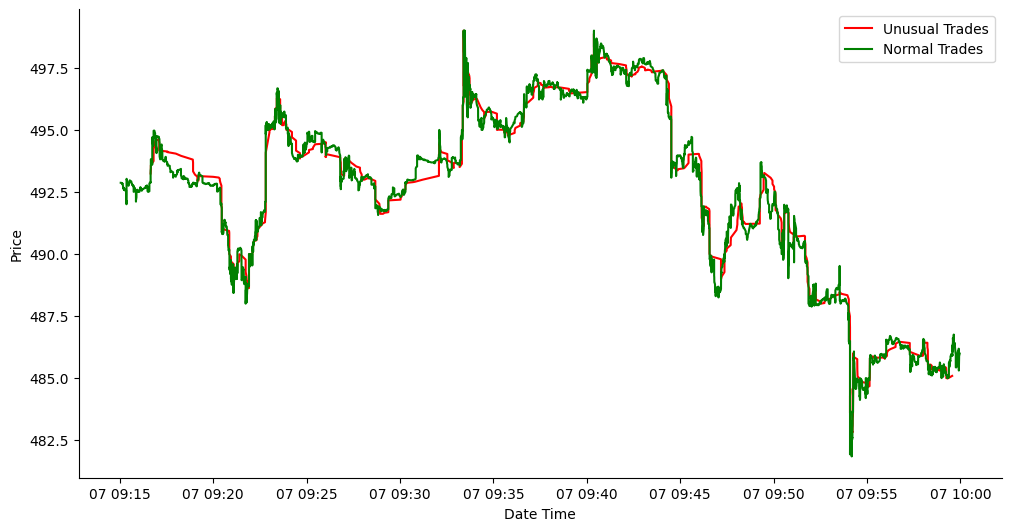

In [ ]:
def _plot_series_price(series, series_name, series_index=0,color='blue',window=10):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series.rolling(window=window)['price'].mean()
  zs = series.rolling(window=window)['vol'].mean()

  plt.plot(xs, ys, label=series_name, color=color)
  # plt.plot(xs, zs, label=series_name, color=color)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_order_comp.sort_values('date', ascending=True)
df_dum_T_sorted = df_dum_T.sort_values('date', ascending=True)
_plot_series_price(df_sorted, 'Unusual Trades',color='red',window=10)
_plot_series_price(df_dum_T_sorted, 'Normal Trades',color='green',window=10)
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date Time')
_ = plt.ylabel('Price')
plt.legend()

In [ ]:
print('% of unusual trades:', round(len(df_order_comp)/len(total_T_order)*100,2))
print('% of usual trades:', round(len(df_dum_T)/len(total_T_order)*100,2))

% of unusual trades: 12.7
% of usual trades: 94.55


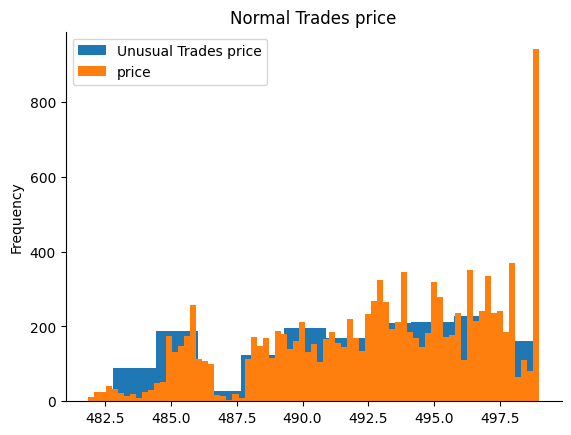

In [ ]:
df_order_comp.rolling(window=10)['price'].mean().plot(kind='hist', bins=10, label='Unusual Trades price')
df_dum_T.rolling(window=10)['price'].mean().plot(kind='hist', bins=75, title='Normal Trades price')
# plt.xlim(460,500)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.legend()

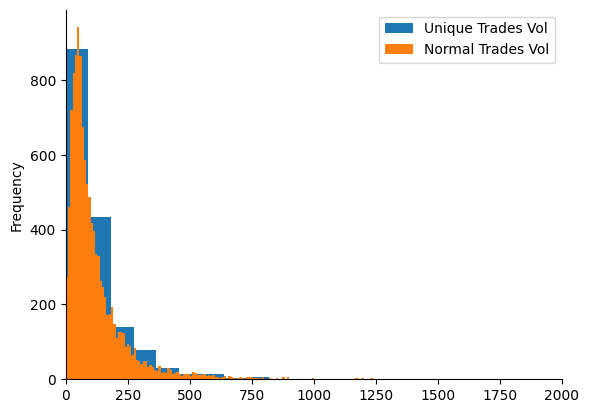

In [ ]:
df_order_comp.rolling(window=10)['vol'].mean().plot(kind='hist', bins=10, label='Unique Trades Vol')
df_dum_T.rolling(window=10)['vol'].mean().plot(kind='hist', bins=150, label='Normal Trades Vol')
plt.xlim(0,2000)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.legend()

# Orders Fulfilled in One Row vs Multiple Rows
We track new orders which were not modified and cancelled throughout the duration and which were 'fullfilled', i.e. their total volume at new order must be equal to the sum of the volumes of the subsequent rows (which can be 1 or more).

In [ ]:
unique_orders=df_dum[df_dum['order_type']=='N']['order_no'].values

In [ ]:
one_row = []
multiple_rows = []
for odr in unique_orders:
  df_temp = df_dum[df_dum['order_no']==odr].sort_values('date', ascending=True)
  if len(df_temp)==2 and df_temp.order_type.values[1]=='T' and df_temp.vol.values[0]==df_temp.vol.values[1]:
    one_row.append(df_temp)
  elif len(df_temp)>2 and df_temp.order_type.values[1:].all()=='T' and df_temp.vol.values[0]==np.sum(df_temp.vol.values[1:]):
    multiple_rows.append(df_temp)
# df_dum[df_dum['order_no']=='1100000064384203']

In [ ]:
print('Orders fulflled in one row: '+str(int(len(one_row)))+'\nOrders fulfilled in multiple rows:'+str(int(len(multiple_rows))))

Orders fulflled in one row: 2570
Orders fulfilled in multiple rows:664


In [ ]:
print('Percentage of orders fulfilled in one row: '+str(round(len(one_row)/len(df_dum)*100,2))+'\nPercentage of orders fulfilled in multiple rows:'+str(round(len(multiple_rows)/len(df_dum)*100,2)))

Percentage of orders fulfilled in one row: 2.01
Percentage of orders fulfilled in multiple rows:0.52


# Orders with volume >1000

In [ ]:
buy_high_vol_orders = df_dum[(df_dum['vol'].values >= 1000) & (df_dum['buy_sell'].values=='B')]
sell_high_vol_orders = df_dum[(df_dum['vol'].values >= 1000) & (df_dum['buy_sell'].values=='S')]

In [ ]:
sell_orders = df_dum[(df_dum['buy_sell'].values=='S')]
buy_orders = df_dum[(df_dum['buy_sell'].values=='B')]

In [ ]:
sell_orders['price'].corr(sell_high_vol_orders['price']),buy_orders['price'].corr(buy_high_vol_orders['price'])

(0.9999999999999998, 1.0)

In [ ]:
high_orders = df_dum[(df_dum['vol'].values >= 1000)]
high_indices = high_orders.index

In [ ]:
df_dum.loc[high_indices]

,index,sno,timestamp_epoch,symbol_id,order_type,buy_sell,order_no,order_no2,price,vol,date
1292437,1293389,225403194,1736241301915474,11971,N,S,1100000057993979,,499.00,5000.0,2025-01-07 09:15:01.915474
1292585,1293537,225484950,1736241310641557,11971,N,S,1100000058014813,,499.00,1000.0,2025-01-07 09:15:10.641557
1292587,1293539,225487556,1736241311015901,11971,N,S,1100000058015471,,493.20,5000.0,2025-01-07 09:15:11.015901
1293239,1294191,225591456,1736241324743273,11971,M,B,1100000057987163,,492.25,2000.0,2025-01-07 09:15:24.743273
1293343,1294295,225635496,1736241330341039,11971,M,B,1100000054855032,,487.00,2000.0,2025-01-07 09:15:30.341039
...,...,...,...,...,...,...,...,...,...,...,...
1419935,1420891,252280527,1736243974587995,11971,M,B,1100000064368595,,486.00,1373.0,2025-01-07 09:59:34.587995
1420045,1421001,252283516,1736243975740494,11971,N,B,1100000064369366,,480.00,1000.0,2025-01-07 09:59:35.740494
1420101,1421057,252289525,1736243978488966,11971,N,S,1100000064370951,,489.00,2000.0,2025-01-07 09:59:38.488966
1420341,1421297,252327349,1736243996339480,11971,N,B,1100000064382712,,485.20,1000.0,2025-01-07 09:59:56.339480


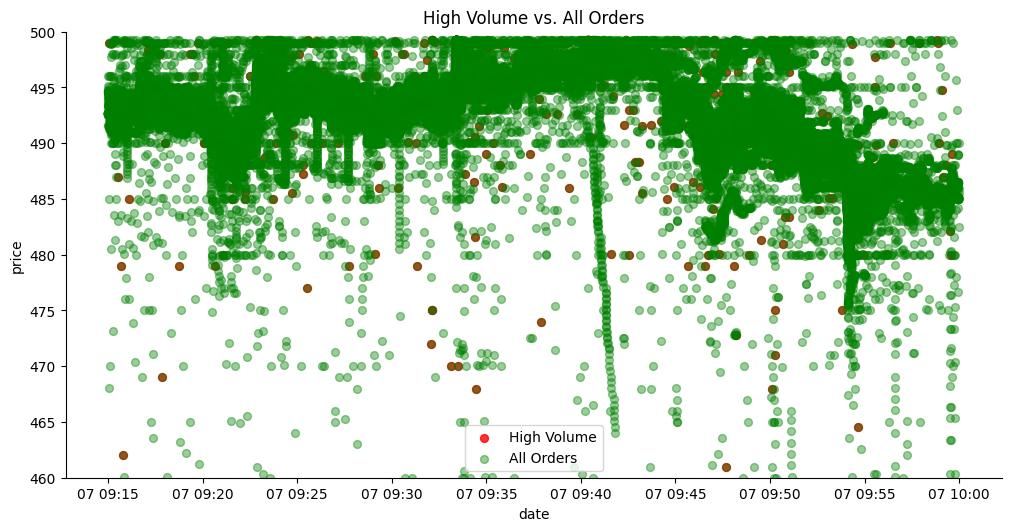

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_dum_sorted = df_dum.sort_values('date', ascending=True)

# Scatter plot for high volume orders (red)
df_dum.loc[high_indices].plot(kind='scatter', x='date', y='price',
                             s=32, alpha=0.8, color='red',
                             label='High Volume', ax=ax)

# Scatter plot for all orders (green)
df_dum.plot(kind='scatter', x='date', y='price',
            s=32, alpha=0.4, color='green',
            label='All Orders', ax=ax)

plt.ylim(460, 500)
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
plt.ylabel('price')
plt.title('High Volume vs. All Orders')
plt.legend()
plt.show()